In [1]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch

class RAFDBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
from rafdb_dataset import RAFDBDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomApply([
        transforms.RandomRotation(5),
        transforms.RandomCrop(64, padding=8)
    ], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(scale=(0.02,0.25)),
])
    
rafdb_dataset_train = RAFDBDataset(csv_file='archive/train_labels.csv',
                            img_dir='archive/DATASET/train/',
                            transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=32, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = RAFDBDataset(csv_file='dataset/vali_labels.csv',
                            img_dir='dataset/validation_set',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=32, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

rafdb_dataset_test = RAFDBDataset(csv_file='archive/test_labels.csv',
                            img_dir='archive/DATASET/test',
                            transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=32, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([8, 3, 64, 64]), labels shape torch.Size([8])
Vali batch: image shape torch.Size([8, 3, 64, 64]), labels shape torch.Size([8])
Test batch: image shape torch.Size([8, 3, 64, 64]), labels shape torch.Size([8])


In [4]:
# class VGG16(nn.Module):
#     def __init__(self, num_classes=6):
#         super(VGG16, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 7 * 7, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x


In [12]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 6)

    def forward(self, x):
        x = F.relu(self.bn1(F.max_pool2d(self.conv1(x), 2)))
        x = F.relu(self.bn2(F.max_pool2d(self.conv2(x), 2)))
        x = F.relu(self.bn3(F.max_pool2d(self.conv3(x), 2)))
        x = self.pool(x)
        x = x.view(-1, 128)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion * planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=6):
#         super(ResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avgpool(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out

# def EmotionClassifierResNet18():
#     return ResNet(BasicBlock, [2, 2, 2, 2])

# model = EmotionClassifierResNet18().to(device)


In [ ]:
# param_grid = {
#     'lr': [0.1, 0.01, 0.001, 0.0001], 
#     'batch_size': [8, 16, 32, 64],  
# }
# grid = ParameterGrid(param_grid)
# results = []

In [23]:
# for params in grid: # Hyperparameter tuning 
#     data_train_loader = DataLoader(rafdb_dataset_train, batch_size=params['batch_size'], shuffle=True, num_workers=4)
#     data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=params['batch_size'], shuffle=False, num_workers=0)
    
#     model = EmotionClassifier().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=params['lr'])
#     criterion = nn.CrossEntropyLoss()
    
#     best_val_acc = 0
#     num_epochs = 15
    
#     for epoch in range(num_epochs):
#         model.train()
#         for i, data in enumerate(tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"), 0):
#             inputs, labels = data[0].to(device), data[1].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#     model.eval()
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for data in data_vali_loader:
#             inputs, labels = data[0].to(device), data[1].to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()
    
#     val_acc = val_correct / val_total
#     best_val_acc = max(best_val_acc, val_acc)
    
#     results.append({
#         'lr': params['lr'],
#         'batch_size': params['batch_size'],
#         'best_val_acc': best_val_acc,
#     })

# for result in results:
#     print(f"LR: {result['lr']}, Batch Size: {result['batch_size']}, Best Val Acc: {result['best_val_acc']}")

# best_params = max(results, key=lambda x: x['best_val_acc'])
# print(f"Best params: {best_params}")

Epoch 1/15:   0%|          | 0/1219 [00:00<?, ?it/s]

Epoch 15/15: 100%|██████████| 153/153 [00:26<00:00,  5.78it/s]


LR: 0.1, Batch Size: 8, Best Val Acc: 0.1669449081803005
LR: 0.01, Batch Size: 8, Best Val Acc: 0.332220367278798
LR: 0.001, Batch Size: 8, Best Val Acc: 0.5308848080133556
LR: 0.0001, Batch Size: 8, Best Val Acc: 0.5058430717863105
LR: 0.1, Batch Size: 16, Best Val Acc: 0.1669449081803005
LR: 0.01, Batch Size: 16, Best Val Acc: 0.4006677796327212
LR: 0.001, Batch Size: 16, Best Val Acc: 0.5091819699499165
LR: 0.0001, Batch Size: 16, Best Val Acc: 0.41235392320534225
LR: 0.1, Batch Size: 32, Best Val Acc: 0.1669449081803005
LR: 0.01, Batch Size: 32, Best Val Acc: 0.44908180300500833
LR: 0.001, Batch Size: 32, Best Val Acc: 0.5025041736227045
LR: 0.0001, Batch Size: 32, Best Val Acc: 0.4273789649415693
LR: 0.1, Batch Size: 64, Best Val Acc: 0.1669449081803005
LR: 0.01, Batch Size: 64, Best Val Acc: 0.4607679465776294
LR: 0.001, Batch Size: 64, Best Val Acc: 0.4240400667779633
LR: 0.0001, Batch Size: 64, Best Val Acc: 0.3739565943238731
Best params: {'lr': 0.001, 'batch_size': 8, 'best_v

In [13]:
model = EmotionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

patience = 5
best_val_acc = 0  
patience_counter = 0

num_epochs = 20

In [14]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/50: 100%|██████████| 4254/4254 [01:19<00:00, 53.72it/s]


Epoch 1, Train Loss: 1.1626297785752975, Train Accuracy: 0.37436816739155987, Test Loss: 1.1041949180057615, Test Accuracy: 0.5117252931323283, Validation Loss: 1.630440636475881, Validation Accuracy: 0.18363939899833054


Epoch 2/50: 100%|██████████| 4254/4254 [01:18<00:00, 54.20it/s]


Epoch 2, Train Loss: 1.0482491980721456, Train Accuracy: 0.4314682026566357, Test Loss: 0.9665597313423221, Test Accuracy: 0.551926298157454, Validation Loss: 1.393833239475886, Validation Accuracy: 0.25041736227045075


Epoch 3/50: 100%|██████████| 4254/4254 [01:17<00:00, 54.54it/s]


Epoch 3, Train Loss: 0.9653248787626841, Train Accuracy: 0.47070059950628895, Test Loss: 0.8901402858587412, Test Accuracy: 0.6088777219430486, Validation Loss: 1.402551916440328, Validation Accuracy: 0.31385642737896496


Epoch 4/50: 100%|██████████| 4254/4254 [01:17<00:00, 55.04it/s]


Epoch 4, Train Loss: 0.9057923870421263, Train Accuracy: 0.5024979428705771, Test Loss: 0.8860121685326299, Test Accuracy: 0.6155778894472361, Validation Loss: 1.4639683932065963, Validation Accuracy: 0.2921535893155259
No improvement in validation accuracy for 1 epochs.


Epoch 5/50: 100%|██████████| 4254/4254 [01:17<00:00, 55.04it/s]


Epoch 5, Train Loss: 0.8580735016423293, Train Accuracy: 0.5246561655107559, Test Loss: 0.7884636523332883, Test Accuracy: 0.6469849246231156, Validation Loss: 1.2231259965896606, Validation Accuracy: 0.34557595993322204


Epoch 6/50: 100%|██████████| 4254/4254 [01:17<00:00, 54.74it/s]


Epoch 6, Train Loss: 0.8156736669164338, Train Accuracy: 0.5418772775361467, Test Loss: 0.7137552171347532, Test Accuracy: 0.6779731993299832, Validation Loss: 1.0911578353246052, Validation Accuracy: 0.3722871452420701


Epoch 7/50: 100%|██████████| 4254/4254 [01:17<00:00, 55.11it/s]


Epoch 7, Train Loss: 0.7852032822996841, Train Accuracy: 0.5537204654990008, Test Loss: 0.7626969136615411, Test Accuracy: 0.6637353433835846, Validation Loss: 1.2820789460341135, Validation Accuracy: 0.3622704507512521
No improvement in validation accuracy for 1 epochs.


Epoch 8/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.32it/s]


Epoch 8, Train Loss: 0.7575602574999911, Train Accuracy: 0.5637122369813095, Test Loss: 0.7027132584274214, Test Accuracy: 0.6708542713567839, Validation Loss: 1.0777988998095194, Validation Accuracy: 0.4040066777963272


Epoch 9/50: 100%|██████████| 4254/4254 [01:17<00:00, 55.13it/s]


Epoch 9, Train Loss: 0.7329436230447387, Train Accuracy: 0.5719701422358058, Test Loss: 0.6774232044541916, Test Accuracy: 0.6804857621440537, Validation Loss: 1.143576326171557, Validation Accuracy: 0.41235392320534225


Epoch 10/50: 100%|██████████| 4254/4254 [01:17<00:00, 55.11it/s]


Epoch 10, Train Loss: 0.7172290550960385, Train Accuracy: 0.5821088515340308, Test Loss: 0.6250250218591862, Test Accuracy: 0.7135678391959799, Validation Loss: 1.0103559543689091, Validation Accuracy: 0.4257095158597663


Epoch 11/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.61it/s]


Epoch 11, Train Loss: 0.6980657381809929, Train Accuracy: 0.5869871870224521, Test Loss: 0.6466799907909588, Test Accuracy: 0.7085427135678392, Validation Loss: 1.0591618879636129, Validation Accuracy: 0.41402337228714525
No improvement in validation accuracy for 1 epochs.


Epoch 12/50: 100%|██████████| 4254/4254 [01:17<00:00, 55.13it/s]


Epoch 12, Train Loss: 0.681042099544944, Train Accuracy: 0.5959503937933467, Test Loss: 0.6134850041672937, Test Accuracy: 0.7219430485762144, Validation Loss: 1.0046496466795602, Validation Accuracy: 0.4574290484140234


Epoch 13/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.48it/s]


Epoch 13, Train Loss: 0.6633816826243529, Train Accuracy: 0.6016515810508992, Test Loss: 0.6150080922112666, Test Accuracy: 0.7139865996649917, Validation Loss: 1.1061151627699535, Validation Accuracy: 0.44240400667779634
No improvement in validation accuracy for 1 epochs.


Epoch 14/50: 100%|██████████| 4254/4254 [01:17<00:00, 54.63it/s]


Epoch 14, Train Loss: 0.6564560474045873, Train Accuracy: 0.6050311508169742, Test Loss: 0.6053576597158975, Test Accuracy: 0.7269681742043551, Validation Loss: 1.0979460614919663, Validation Accuracy: 0.4290484140233723
No improvement in validation accuracy for 2 epochs.


Epoch 15/50: 100%|██████████| 4254/4254 [01:18<00:00, 54.43it/s]


Epoch 15, Train Loss: 0.6404798388096702, Train Accuracy: 0.6106441753849771, Test Loss: 0.6361748748163016, Test Accuracy: 0.699748743718593, Validation Loss: 0.965173176129659, Validation Accuracy: 0.46410684474123537


Epoch 16/50: 100%|██████████| 4254/4254 [01:19<00:00, 53.28it/s]


Epoch 16, Train Loss: 0.6295322572057572, Train Accuracy: 0.6157869989420477, Test Loss: 0.6108740516143998, Test Accuracy: 0.7085427135678392, Validation Loss: 1.0151441615819932, Validation Accuracy: 0.4757929883138564


Epoch 17/50: 100%|██████████| 4254/4254 [01:19<00:00, 53.50it/s]


Epoch 17, Train Loss: 0.6223314339605909, Train Accuracy: 0.617844128364876, Test Loss: 0.5974130940103412, Test Accuracy: 0.7223618090452262, Validation Loss: 0.9036719620227813, Validation Accuracy: 0.48414023372287146


Epoch 18/50: 100%|██████████| 4254/4254 [01:17<00:00, 54.62it/s]


Epoch 18, Train Loss: 0.6138190162732854, Train Accuracy: 0.6220465499000822, Test Loss: 0.5888803515670491, Test Accuracy: 0.7156616415410385, Validation Loss: 1.0056691980361938, Validation Accuracy: 0.4507512520868113
No improvement in validation accuracy for 1 epochs.


Epoch 19/50: 100%|██████████| 4254/4254 [01:18<00:00, 54.24it/s]


Epoch 19, Train Loss: 0.6039574642353273, Train Accuracy: 0.6242800047020101, Test Loss: 0.5906704146302862, Test Accuracy: 0.7135678391959799, Validation Loss: 0.8519870805740356, Validation Accuracy: 0.4974958263772955


Epoch 20/50: 100%|██████████| 4254/4254 [01:19<00:00, 53.75it/s]


Epoch 20, Train Loss: 0.5957954697099439, Train Accuracy: 0.6318032208769249, Test Loss: 0.5917507320592634, Test Accuracy: 0.7261306532663316, Validation Loss: 0.9187887677550316, Validation Accuracy: 0.5075125208681135


Epoch 21/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.51it/s]


Epoch 21, Train Loss: 0.589256433865185, Train Accuracy: 0.6310979193605266, Test Loss: 0.5563943319452497, Test Accuracy: 0.7361809045226131, Validation Loss: 0.9959717919429143, Validation Accuracy: 0.4791318864774624
No improvement in validation accuracy for 1 epochs.


Epoch 22/50: 100%|██████████| 4254/4254 [01:17<00:00, 54.96it/s]


Epoch 22, Train Loss: 0.5782239154614132, Train Accuracy: 0.635535441401199, Test Loss: 0.6468903678453786, Test Accuracy: 0.7060301507537688, Validation Loss: 1.1817099018891652, Validation Accuracy: 0.43906510851419034
No improvement in validation accuracy for 2 epochs.


Epoch 23/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.58it/s]


Epoch 23, Train Loss: 0.571679138478041, Train Accuracy: 0.6388856236040907, Test Loss: 0.5535445294551626, Test Accuracy: 0.740787269681742, Validation Loss: 0.934253798176845, Validation Accuracy: 0.5025041736227045
No improvement in validation accuracy for 3 epochs.


Epoch 24/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.54it/s]


Epoch 24, Train Loss: 0.5712128276737485, Train Accuracy: 0.6376513459503937, Test Loss: 0.5905937598893625, Test Accuracy: 0.7236180904522613, Validation Loss: 1.006297498246034, Validation Accuracy: 0.4974958263772955
No improvement in validation accuracy for 4 epochs.


Epoch 25/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.46it/s]


Epoch 25, Train Loss: 0.5631210219446039, Train Accuracy: 0.6406194898319031, Test Loss: 0.5460595841142645, Test Accuracy: 0.7458123953098827, Validation Loss: 0.9011162795623143, Validation Accuracy: 0.5158597662771286


Epoch 26/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.41it/s]


Epoch 26, Train Loss: 0.5600649478891712, Train Accuracy: 0.6427060068179147, Test Loss: 0.5400783977032106, Test Accuracy: 0.7550251256281407, Validation Loss: 0.8451233208179474, Validation Accuracy: 0.5475792988313857


Epoch 27/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.69it/s]


Epoch 27, Train Loss: 0.5505182399481472, Train Accuracy: 0.645115786998942, Test Loss: 0.5430616267137603, Test Accuracy: 0.7374371859296482, Validation Loss: 0.8778353305657705, Validation Accuracy: 0.5208681135225376
No improvement in validation accuracy for 1 epochs.


Epoch 28/50: 100%|██████████| 4254/4254 [01:18<00:00, 54.23it/s]


Epoch 28, Train Loss: 0.5454810830332307, Train Accuracy: 0.6500822851769131, Test Loss: 0.5310941769688524, Test Accuracy: 0.7520938023450586, Validation Loss: 0.9353489249944686, Validation Accuracy: 0.5041736227045075
No improvement in validation accuracy for 2 epochs.


Epoch 29/50: 100%|██████████| 4254/4254 [01:19<00:00, 53.59it/s]


Epoch 29, Train Loss: 0.5398224418156189, Train Accuracy: 0.6503761608087457, Test Loss: 0.5509353397526221, Test Accuracy: 0.7432998324958124, Validation Loss: 0.9818180494010449, Validation Accuracy: 0.4774624373956594
No improvement in validation accuracy for 3 epochs.


Epoch 30/50: 100%|██████████| 4254/4254 [01:18<00:00, 53.86it/s]


Epoch 30, Train Loss: 0.5464505264977783, Train Accuracy: 0.6479369930645351, Test Loss: 0.5841929415929252, Test Accuracy: 0.7395309882747069, Validation Loss: 0.9859482988715171, Validation Accuracy: 0.4691151919866444
No improvement in validation accuracy for 4 epochs.


Epoch 31/50: 100%|██████████| 4254/4254 [01:20<00:00, 53.11it/s]


Epoch 31, Train Loss: 0.531495781312817, Train Accuracy: 0.655019395791701, Test Loss: 0.5726049126602435, Test Accuracy: 0.731574539363484, Validation Loss: 0.8809782384832701, Validation Accuracy: 0.5258764607679466
No improvement in validation accuracy for 5 epochs.


Epoch 32/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.36it/s]


Epoch 32, Train Loss: 0.527567891991993, Train Accuracy: 0.6561067356294816, Test Loss: 0.5348017245451655, Test Accuracy: 0.7378559463986599, Validation Loss: 0.9070140778024991, Validation Accuracy: 0.5191986644407346
No improvement in validation accuracy for 6 epochs.


Epoch 33/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.27it/s]


Epoch 33, Train Loss: 0.5252782086509866, Train Accuracy: 0.6562242858822146, Test Loss: 0.5390184909957196, Test Accuracy: 0.7479061976549414, Validation Loss: 0.9364299393196901, Validation Accuracy: 0.5258764607679466
No improvement in validation accuracy for 7 epochs.


Epoch 34/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.51it/s]


Epoch 34, Train Loss: 0.5224470497743013, Train Accuracy: 0.6583401904314095, Test Loss: 0.5532184223937225, Test Accuracy: 0.7449748743718593, Validation Loss: 1.1050211862971386, Validation Accuracy: 0.48080133555926546
No improvement in validation accuracy for 8 epochs.


Epoch 35/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.38it/s]


Epoch 35, Train Loss: 0.5152578086350997, Train Accuracy: 0.6589279416950746, Test Loss: 0.5529339677968801, Test Accuracy: 0.7487437185929648, Validation Loss: 1.0924465397000314, Validation Accuracy: 0.4741235392320534
No improvement in validation accuracy for 9 epochs.


Epoch 36/50: 100%|██████████| 4254/4254 [01:17<00:00, 54.61it/s]


Epoch 36, Train Loss: 0.513788252172028, Train Accuracy: 0.6617197601974845, Test Loss: 0.614313279910879, Test Accuracy: 0.7093802345058626, Validation Loss: 0.8987617115179698, Validation Accuracy: 0.5191986644407346
No improvement in validation accuracy for 10 epochs.


Epoch 37/50: 100%|██████████| 4254/4254 [01:16<00:00, 55.37it/s]


Epoch 37, Train Loss: 0.5107232419666989, Train Accuracy: 0.6631009756670977, Test Loss: 0.5566090265488296, Test Accuracy: 0.7441373534338358, Validation Loss: 0.9484049906333287, Validation Accuracy: 0.5125208681135225
No improvement in validation accuracy for 11 epochs.
Stopping early due to lack of improvement in validation accuracy.


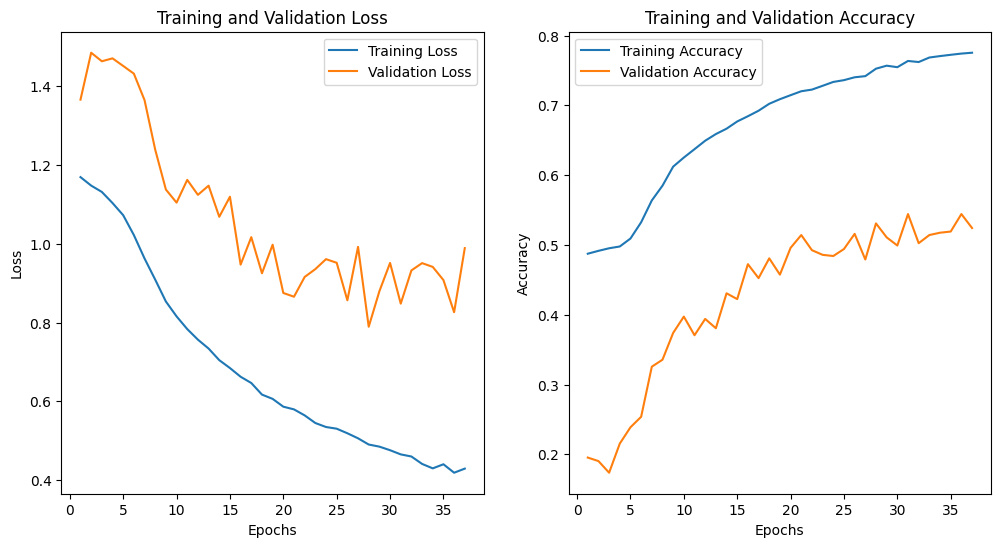

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies')
plt.legend()

plt.show()

In [ ]:
df = pd.DataFrame({
    'Epoch': range(1, num_epochs+1),
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('training_metrics.csv', index=False)